# Import Package

In [17]:
# Reference
# https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import copy
from PIL import Image
import numpy as np

# Check GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load Image

In [4]:
imsize = [512, 512] if torch.cuda.is_available() else [128, 128]  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


# style_img = image_loader("images/ghi.jpg")
style_img = image_loader("images/chihiro015.jpg")
# style_img = image_loader("images/A.jpg")
content_img = image_loader("images/B.jpg")
# content_img = image_loader("images/chihiro015.jpg")
print(style_img.shape)
print(content_img.shape)
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


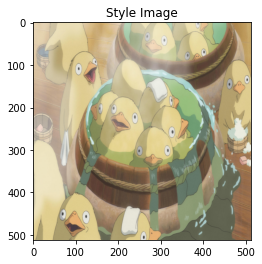

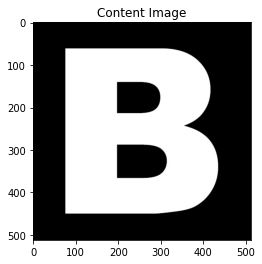

In [5]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
plt.ion()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

# Loss Define

In [6]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)



# Load pretrain model VGG19

In [7]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [8]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [9]:
# content_layers_default = ['conv_4']
#style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
#

content_layers_default = ['conv_3']
# style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4','conv_5', 'conv_6', 'conv_7','conv_8','conv_9','conv_10','conv_11','conv_12']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

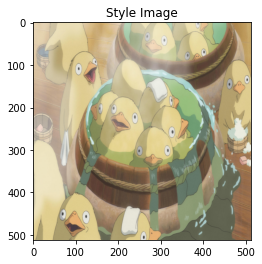

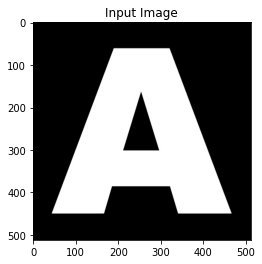

In [151]:
content_img = image_loader("images/B.jpg")
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(input_img, title='Input Image')

# Model main function

In [11]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 200 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                
                plt.figure()
                imshow(input_img, title='Output Image')
                plt.show()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

# Run model and check the output result

In [ ]:
def image_loader2(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image

def save_result_image(output, current_char):
    save_image(output, 'result.png')
    # put result image
    img1 = image_loader2("result.png").numpy()
    # put orginial letter image (black and white one)
    img_mask = image_loader2("images/"+current_char+".jpg").clamp_(0, 1).numpy()
    new_mask_image = np.where(img_mask>=1, img1, 1)
#     imshow(torch.from_numpy(new_mask_image), title='Output Image')
    save_image(torch.from_numpy(new_mask_image) , 'result_mask.png')


    #Make background transparent
    #===================
    img = Image.open('result_mask.png')
    img = img.convert("RGBA")
    pixdata = img.load()
    width, height = img.size
    for y in range(height):
        for x in range(width):
            if pixdata[x, y] == (255, 255, 255, 255):
                pixdata[x, y] = (255, 255, 255, 0)
    img.save("output/result_mask_"+current_char+".png", "PNG")

    
current_char = 'C'
for i in range(24):
    content_img = image_loader("images/"+current_char+".jpg")
    input_img = content_img.clone()
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=2200,
                            style_weight=10000000, content_weight=1)
    save_result_image(output, current_char)
    current_char = chr(ord(current_char) + 1)
# save_result_image(output, current_char)
# content_img = image_loader("images/B.jpg")
# input_img = content_img.clone()
# output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                             content_img, style_img, input_img, num_steps=2200,
#                             style_weight=10000000, content_weight=1)
# save_result_image(output)

# plt.figure()
# imshow(output, title='Output Image')
# plt.ioff()
# plt.show()

# Mask Image

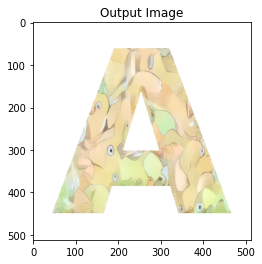